In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import sys

In [2]:
plt.rcParams['figure.figsize'] = (15, 10)

In [3]:
sys.path.append('../')

In [4]:
def load_pickle(fname):
    path = Path(fname)
    path: Path
    if path.exists():
        return pickle.load(open(fname, 'rb'))
    else:
        return None

In [127]:
def read_auc_aupr_data(model, dataset, is_directed, k):
    rows = []
    dataset = dataset + '_directed' if is_directed else dataset + '_undirected'
    
    for i in range(10):
        auc_pickle_path = f'../test_results/static/{dataset}/{model}_auc_{i}.pkl'
        aupr_pickle_path = f'../test_results/static/{dataset}/{model}_aupr_at_k{k}_{i}.pkl'
        
        auc_data = load_pickle(auc_pickle_path)
        aupr_data = load_pickle(aupr_pickle_path)
        
        if auc_data is None or aupr_data is None:
            continue
        
        auc = auc_data['auc']
        if k == 2:
            aupr_2 = aupr_data['aupr']
            aupr_3 = None
        else:
            aupr_2 = None
            aupr_3 = aupr_data['aupr']
        
        row = {'model': model, 'dataset': dataset, f'AUPR_2': aupr_2, 'AUPR_3': aupr_3, 'AUC': auc}
        rows.append(row)
    return pd.DataFrame(rows)

In [128]:
datasets = ('citeseer', 'cora', 'eucore')
models = ('SST_SVM', 'SST_SVM_3', 'GCN_AE', 'GCN_VAE', 'Linear_AE', 'Linear_VAE', 'Random', 'CommonNeighbors', 'Deep_GCN_AE', 
          'Deep_GCN_VAE', 'Gravity_GCN_AE', 'Gravity_GCN_VAE')
ks = [2, 3]
dfs = []

for is_directed in (False, True):
    for dataset in datasets:
        for model in models: 
            for k in ks:
                df = read_auc_aupr_data(model=model, dataset=dataset, is_directed=is_directed, k=k)
                dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [130]:
df.model.value_counts()

CommonNeighbors    120
SST_SVM_3          120
SST_SVM            100
Linear_AE           60
Gravity_GCN_AE      60
Deep_GCN_VAE        60
GCN_AE              60
Random              60
GCN_VAE             60
Deep_GCN_AE         60
Linear_VAE          60
Gravity_GCN_VAE     60
Name: model, dtype: int64

In [131]:
df.dataset.value_counts()

citeseer_undirected    200
cora_undirected        200
eucore_undirected      200
citeseer_directed      100
cora_directed          100
eucore_directed         80
Name: dataset, dtype: int64

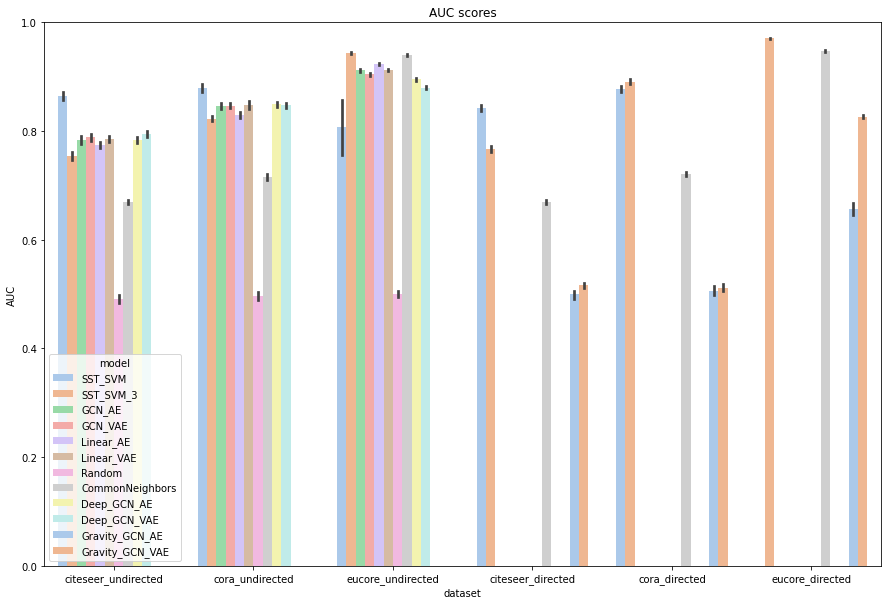

In [132]:
ax = plt.gca()
plt.title('AUC scores')
ax.set_ylim((0, 1))
sns.barplot(x='dataset', y='AUC', hue='model', data=df, ax=ax, palette=sns.color_palette('pastel'));
# plt.savefig('./plots/AUC.png', dpi=500, bbox_inches='tight')

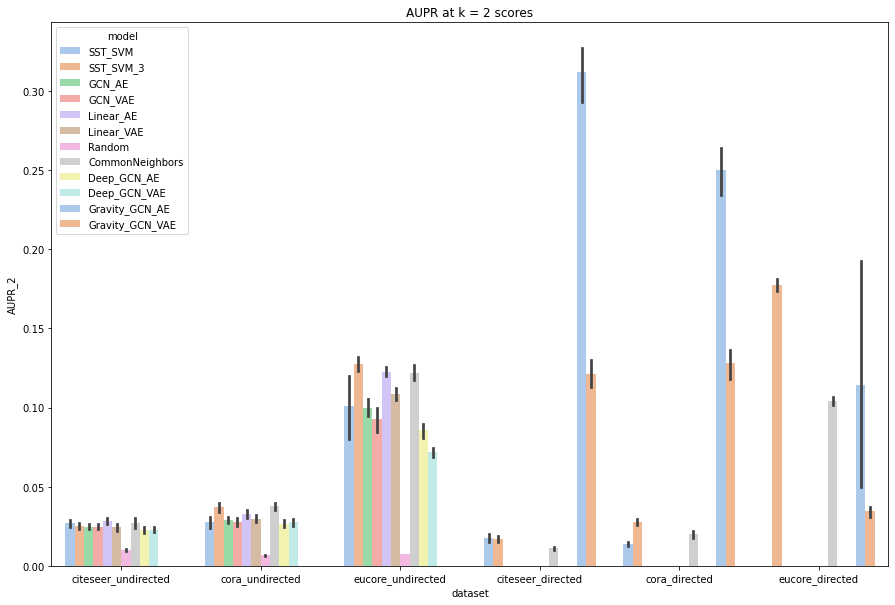

In [133]:
ax = plt.gca()
k = 2
plt.title(f'AUPR at k = {k} scores')
# ax.set_ylim((0, 1))
sns.barplot(x='dataset', y=f'AUPR_{k}', hue='model', data=df, ax=ax, palette=sns.color_palette('pastel'));
# plt.savefig(f'./plots/AUPR_{k}_undirected.png', dpi=500, bbox_inches='tight')

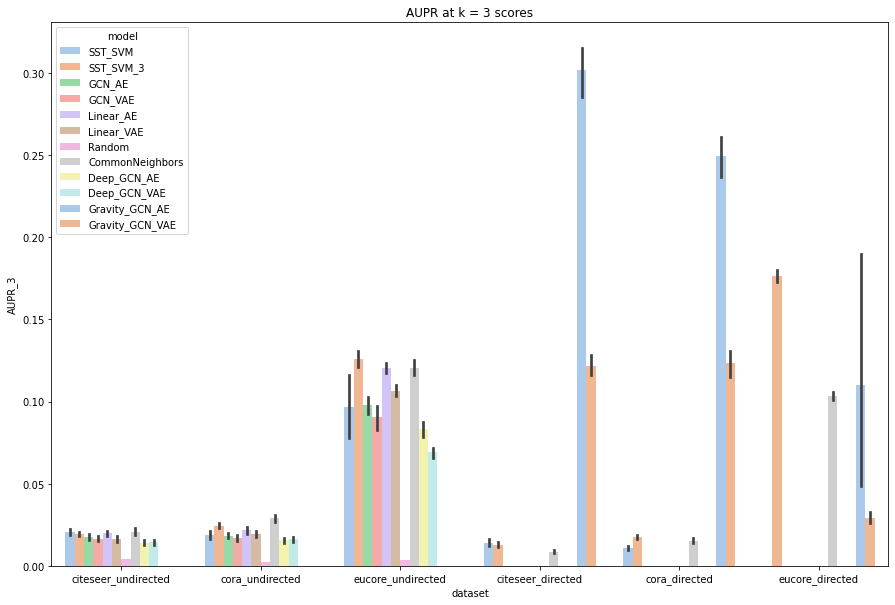

In [134]:
ax = plt.gca()
k = 3
plt.title(f'AUPR at k = {k} scores')
# ax.set_ylim((0, 1))
sns.barplot(x='dataset', y=f'AUPR_{k}', hue='model', data=df, ax=ax, palette=sns.color_palette('pastel'));
# plt.savefig(f'./plots/AUPR_{k}_undirected.png', dpi=500, bbox_inches='tight')

In [12]:
thing = load_pickle(f'../test_results/static/karate_undirected/SST_SVM_aupr_at_k2_0.pkl')

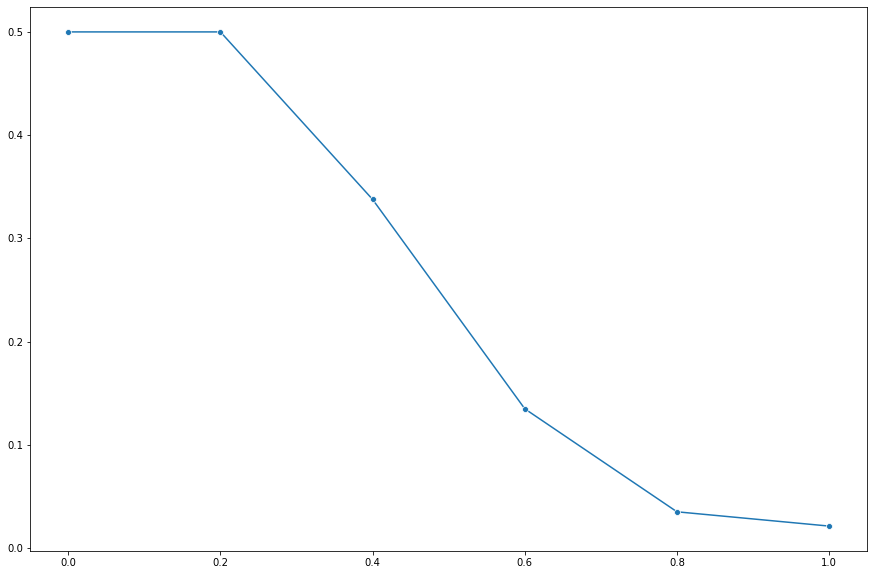

In [13]:
sns.lineplot(x=thing['recalls'], y=thing['precisions'], ci=None, marker='o');

In [135]:
# Precision Recall stuff
# too many points to plot -- bucket the points within an epsilon

In [213]:
def get_representative_aupr_pickle(model, dataset):
    pickles = []
    for i in range(10):
        pkl = load_pickle(f'../test_results/static/{dataset}/{model}_aupr_at_k3_{i}.pkl')
        if pkl is None:
            continue
        pickles.append(pkl)

    if len(pickles) == 0:
        return None 
    
    aupr_attr = 'stingy_aupr'
    mean_aupr = np.mean([pkl[aupr_attr] for pkl in pickles])

    best_pickle = None
    best_score = np.inf
    
    for i, pkl in enumerate(pickles):
        if np.abs(pkl[aupr_attr] - mean_aupr) < best_score:
            best_score = np.abs(pkl[aupr_attr] - mean_aupr)
            best_pickle = i, pkl['recalls'], pkl['precisions']
            
    return best_pickle

In [222]:
def filter_points(prec, rec):
    filtered_points = set()

    for x, y in zip(rec, prec):
        filtered_points.add((round(x, 4), round(y, 4)))
    
    X, Y = [], []
    for x, y in filtered_points:
        X.append(x)
        Y.append(y)
    return X, Y

In [223]:
datasets = ('citeseer', 'cora', 'eucore')
models = ('SST_SVM', 'SST_SVM_3', 'GCN_AE', 'GCN_VAE', 'Linear_AE', 'Linear_VAE', 'Random', 'CommonNeighbors', 'Deep_GCN_AE', 
          'Deep_GCN_VAE', 'Gravity_GCN_AE', 'Gravity_GCN_VAE')
ks = [3]
rows = []

for is_directed in (False, True):
    for dataset in datasets:
        dataset = f'{dataset}_directed' if is_directed else f'{dataset}_undirected'
        for model in models: 
            for k in ks:
                
                things = get_representative_aupr_pickle(model=model, dataset=dataset)
                if things is None:
                    continue
                _, rec, prec = things
                rec, prec = filter_points(rec=rec, prec=prec)
                row = {'dataset': dataset, 'model': model, 'prec': prec, 'rec': rec}
                rows.append(row)
df = pd.DataFrame(rows)

In [224]:
df.head()

,dataset,model,prec,rec
0,citeseer_undirected,SST_SVM,"[0.0242, 0.0634, 0.0056, 0.0292, 0.0326, 0.037...","[0.234, 0.083, 0.8755, 0.2038, 0.1887, 0.1811,..."
1,citeseer_undirected,SST_SVM_3,"[0.0315, 0.033, 0.0093, 0.0288, 0.0439, 0.0423...","[0.2415, 0.2007, 0.6429, 0.2619, 0.1259, 0.102..."
2,citeseer_undirected,GCN_AE,"[0.0103, 0.0341, 0.045, 0.0593, 0.027, 0.049, ...","[0.668, 0.164, 0.04, 0.032, 0.252, 0.06, 0.22,..."
3,citeseer_undirected,GCN_VAE,"[0.0325, 0.0377, 0.0625, 0.0046, 0.0046, 0.023...","[0.1054, 0.0714, 0.0204, 0.9694, 0.9252, 0.132..."
4,citeseer_undirected,Linear_AE,"[0.0344, 0.0485, 0.046, 0.0157, 0.0317, 0.0434...","[0.1115, 0.0692, 0.0808, 0.4346, 0.1115, 0.073..."


In [225]:
df.to_pickle('./PR_df.pickle')  # save a pickle for posteriority

In [226]:
pr_df = df

In [228]:
pr_df.shape

(44, 4)

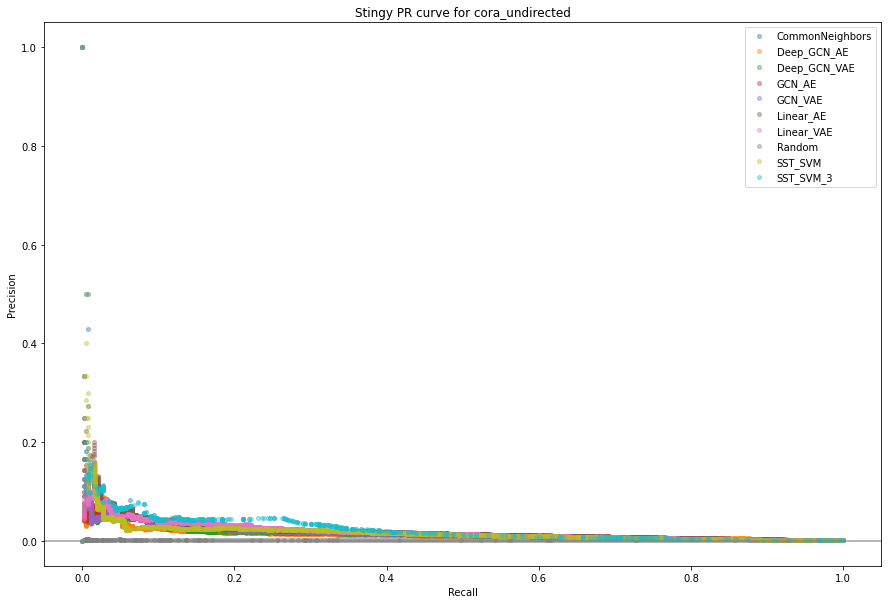

In [254]:
dataset = 'cora_undirected'
filtered_df = pr_df[pr_df.dataset==dataset]

ax = plt.gca()

for model_name, model_df in filtered_df.groupby('model'):
    for i, row in model_df.iterrows():
        rec, prec = row['rec'], row['prec']
        plt.plot(rec, prec, 'o', label=model_name, alpha=0.4, markersize=4);
        
ax.axhline(0, c='gray', alpha=0.75)

plt.title(f'Stingy PR curve for {dataset}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best');
plt.savefig(f'./plots/{dataset}_stingy_PR_curves.png', dpi=500, bbox_inches='tight')

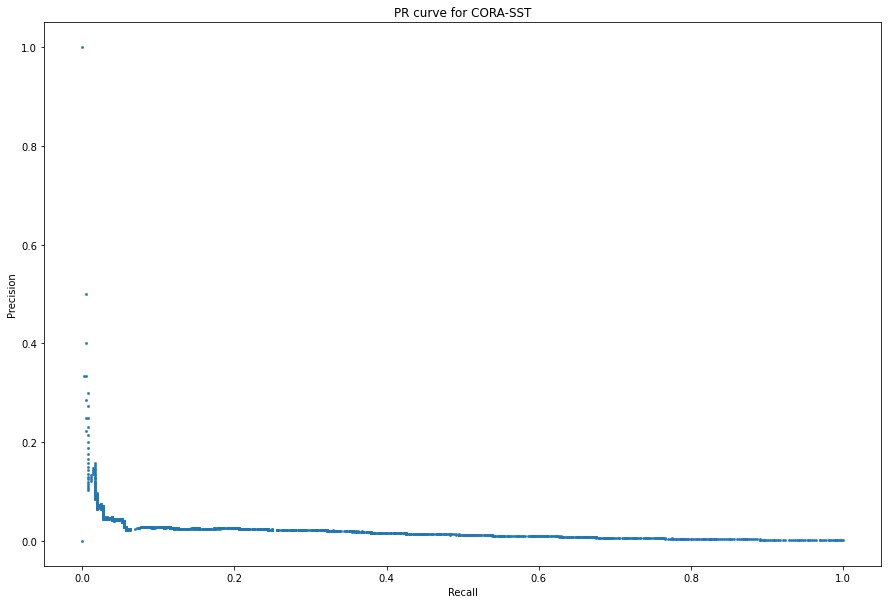

In [198]:
plt.plot(X, Y, 's', markersize=1.5);
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.title('Stingy PR curve for CORA-SST');

In [179]:
list(filtered_points)[: 5]

[(0.165, 0.025),
 (0.157, 0.025),
 (0.038, 0.047),
 (0.019, 0.089),
 (0.019, 0.097)]

In [171]:
list(best_pickle[1]) == sorted(best_pickle[1]), list(best_pickle[2]) == sorted(best_pickle[2])

(False, False)

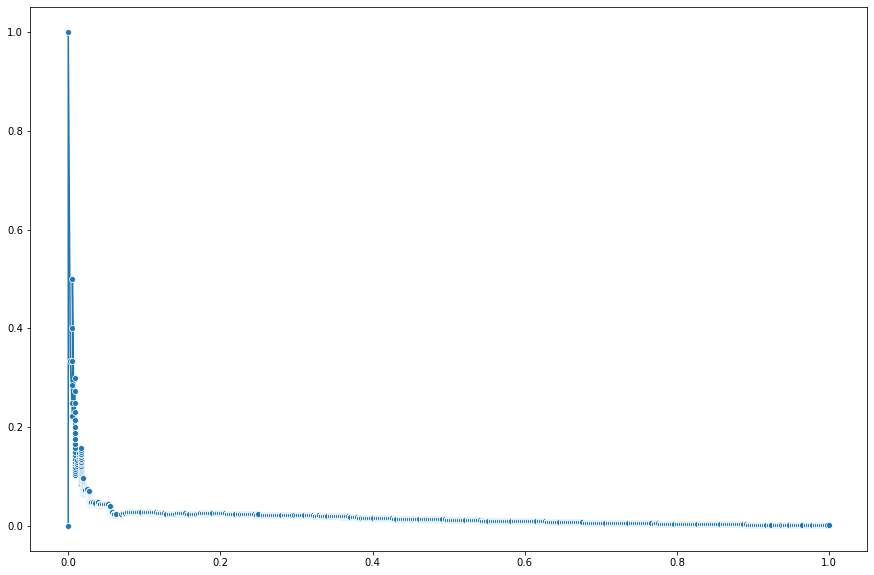

In [163]:
sns.lineplot(best_pickle[1], y=best_pickle[2], ci=None, estimator=None, marker='o');

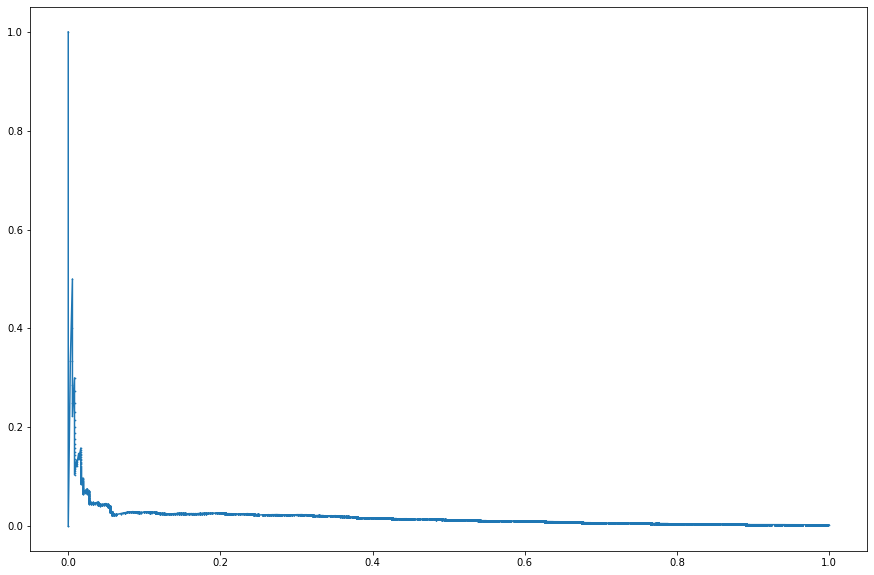

In [164]:
plt.plot(best_pickle[1], best_pickle[2], marker='o', markersize=0.7);